<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/VLM_demo/MedSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- [Segment anything in medical images](https://www.nature.com/articles/s41467-024-44824-z)
- [github repo](https://github.com/bowang-lab/MedSAM)

In [ ]:
!pip install git+https://github.com/bowang-lab/MedSAM.git

  Cloning https://github.com/bowang-lab/MedSAM.git to /tmp/pip-req-build-_9fwosmu
  Running command git clone --filter=blob:none --quiet https://github.com/bowang-lab/MedSAM.git /tmp/pip-req-build-_9fwosmu
  Resolved https://github.com/bowang-lab/MedSAM.git to commit 6c1e850b8729ba9cc9bcd1e92ec99eee5a217793
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.3/380.3 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 7.3 MB/s eta 0:00:00
   

In [ ]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    print(sparse_embeddings.shape, dense_embeddings.shape)
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg, low_res_logits


In [ ]:
# download model and data
img_id = '1Qf0IQF1zTwOJ4Fh4Ix5rtVhR9cnNbI2M'
!gdown $img_id
model_id = "1UAmWL88roYR7wKlnApw5Bcuzf2iQgk6_&confirm=t"
!gdown $model_id

Downloading...
From: https://drive.google.com/uc?id=1Qf0IQF1zTwOJ4Fh4Ix5rtVhR9cnNbI2M
To: /content/img_demo.png
100% 87.9k/87.9k [00:00<00:00, 125MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1UAmWL88roYR7wKlnApw5Bcuzf2iQgk6_
From (redirected): https://drive.google.com/uc?id=1UAmWL88roYR7wKlnApw5Bcuzf2iQgk6_&confirm=t&uuid=43e8001f-8c63-47fa-a8ab-9bba48944a09
To: /content/medsam_vit_b.pth
100% 375M/375M [00:04<00:00, 86.0MB/s]


In [ ]:
#%% load model and image
MedSAM_CKPT_PATH = "medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread('img_demo.png')
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

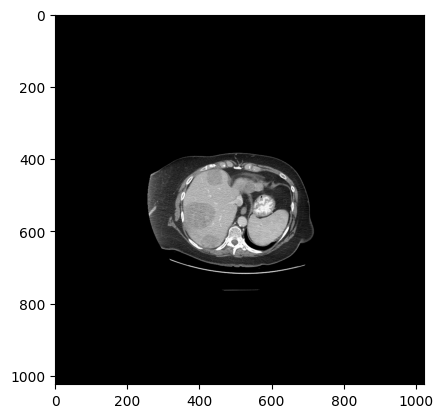

In [ ]:
res = torchvision.transforms.CenterCrop([1024, 1024])
resized = res(torch.tensor(img_3c).permute(-1, 0, 1))
resized.shape
plt.imshow(resized.permute(1,2,0))

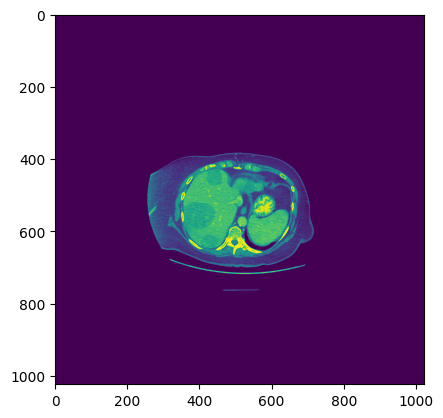

In [ ]:
plt.imshow(img_1024[0, 0].cpu())

In [ ]:
#%% image preprocessing and model inference
import torchvision
img_1024_tensor = resized.unsqueeze(0).to(device)
img_1024 = (img_1024_tensor - img_1024_tensor.min()) / np.clip(
    img_1024_tensor.max().item() - img_1024_tensor.min().item(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)

box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor.float()) # (1, 256, 64, 64)

medsam_seg, logits = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

torch.Size([1, 2, 256]) torch.Size([1, 256, 64, 64])


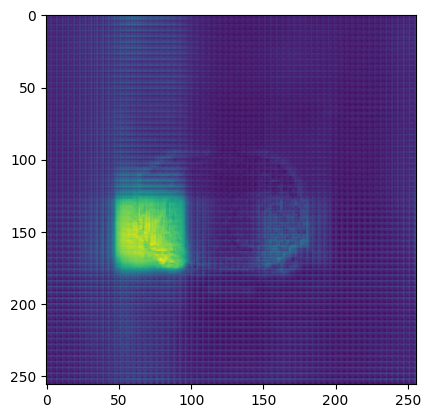

In [ ]:
plt.imshow(logits[0,0].cpu())

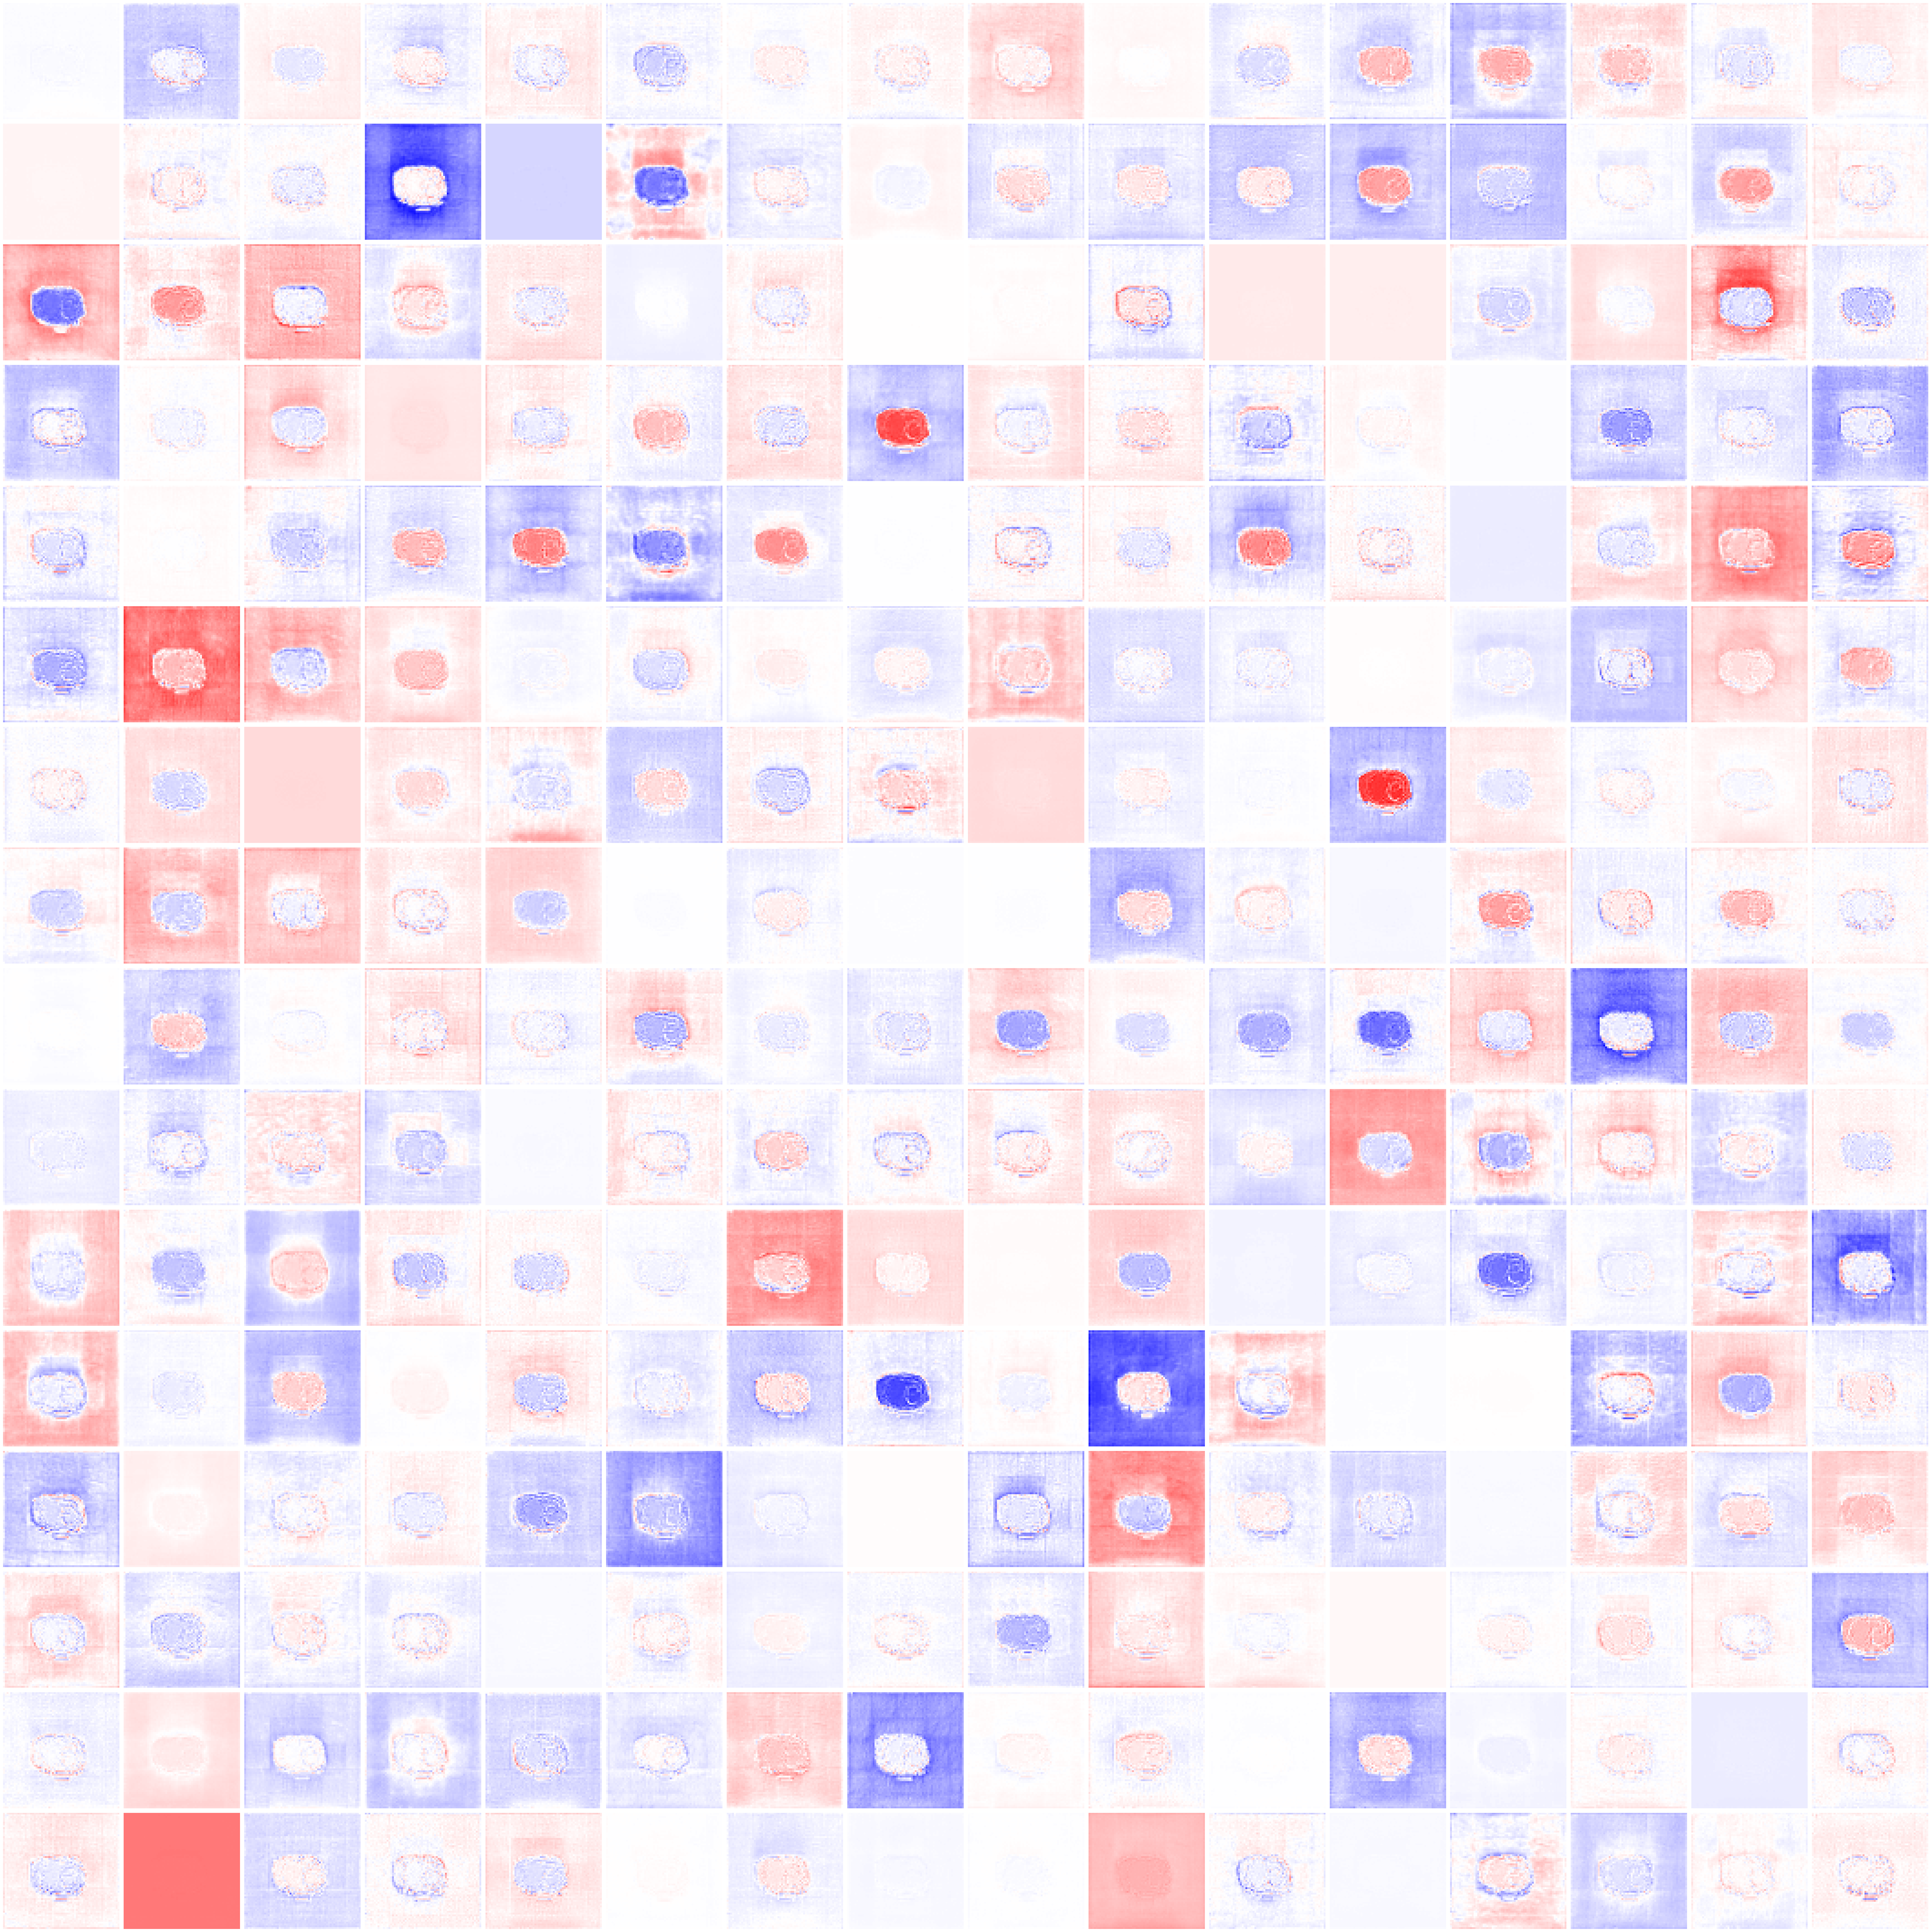

In [ ]:
import torch
scale=4
fig = plt.figure(figsize=(16*scale, 16*scale))
for i in range(image_embedding.shape[1]):
    plt.subplot(16, 16, i+1)
    plt.imshow(image_embedding[0, i].detach().cpu(), cmap='bwr', vmin=-image_embedding.abs().max(), vmax=image_embedding.abs().max())
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
#%% image preprocessing and model inference
import torchvision
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg, logits = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

torch.Size([1, 2, 256]) torch.Size([1, 256, 64, 64])


In [ ]:
image_embedding.shape

torch.Size([1, 256, 64, 64])

(array([32097., 30011.,  1069.,   464.,   351.,   285.,   208.,   128.,
          152.,   771.]),
 array([-22.1193676 , -18.52790833, -14.93645   , -11.34499168,
         -7.75353289,  -4.16207409,  -0.57061541,   3.02084327,
          6.61230183,  10.2037611 ,  13.79521942]),
 <BarContainer object of 10 artists>)

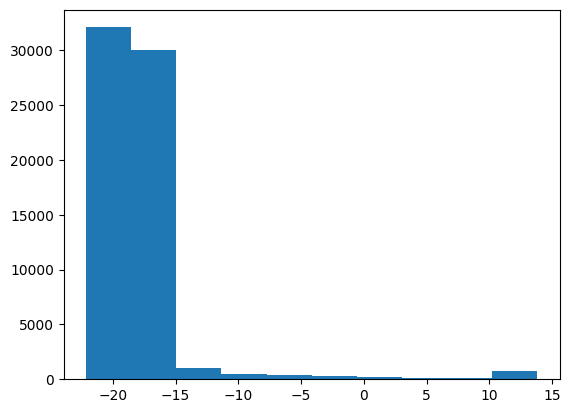

In [ ]:
plt.hist(logits.view(-1).detach().cpu())

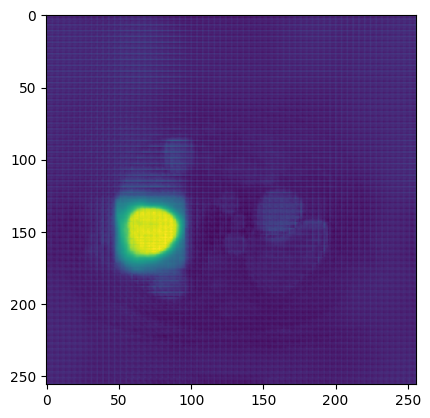

In [ ]:
plt.imshow(logits[0,0].detach().cpu())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm as tsn


def plotImages(img_arr, lbl_arr, colors_arr=None, figsize=(8, 4), mag=2, mean=0., std =1.):

    if len(img_arr) <= min(figsize): rc = (1, len(img_arr))
    else: rc = (figsize[1], min(len(img_arr)//figsize[1], figsize[0]))
    fig, axes = plt.subplots(rc[0], rc[1], figsize=(rc[1]*mag, rc[0]*mag))
    if len(img_arr) != 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    if colors_arr is None: colors_arr = ['k']*len(lbl_arr)
    for img, lbl, c, ax in zip( img_arr, lbl_arr, colors_arr, axes):
        img = img.numpy().transpose((1,2,0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(lbl, color=c)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# plot feature maps
def plotFeaturemaps(maps, max_ch=12, top=None, figsize=(8, 3), mag=1):

    if maps.ndim == 1:
        plt.figure(figsize=figsize)
        plt.bar(np.arange(maps.shape[0]), maps, width=1.0)
        plt.tight_layout()
        plt.show()
        return

    if maps.ndim != 3: return
    # maps.shape = (ch, h, w)
    if top is not None:
        nmaps = min(top, maps.shape[0])
        nrows, ncols = 1, nmaps
        channels = np.argsort(-np.sum(np.abs(maps.reshape((maps.shape[0],-1))**2), axis=1))[:nmaps]
    else:
        nmaps = min(maps.shape[0], max_ch*max_ch)
        ncols = int(np.ceil(np.sqrt(nmaps)))
        nrows = int(np.floor(nmaps / ncols))
        nmaps = nrows * ncols
        channels = range(nmaps)

    norm = tsn(vmin=np.minimum(maps[:].min(),-1e-6), vcenter=0, vmax=np.maximum(maps[:].max(),1e-6)) # maps[channels]
    fig = plt.figure(figsize=(ncols*mag, nrows*mag))
    for ch in range(nmaps):
        ax1 = fig.add_subplot(nrows, ncols, ch+1)
        ax1.imshow(maps[channels[ch]], cmap='bwr_r', norm=norm)#, aspect='equal')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.tight_layout()
    plt.show()

from matplotlib import cm as cmap
# x[H,W]
def toColorImg(x, cm='bwr_r', norm=None):
    if norm is None:
        norm = tsn(vmin=np.minimum(x[:].min(),-1e-6), vcenter=0, vmax=np.maximum(x[:].max(),1e-6)) # maps[channels]
    sm = cmap.ScalarMappable(norm=norm, cmap=cm)
    return sm.to_rgba(x)[:,:,:3]

In [ ]:
medsam_model.image_encoder

ImageEncoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (lin1): Linear(in_features=768, out_features=3072, bias=True)
        (lin2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU(approximate='none')
      )
    )
  )
  (neck): Sequential(
    (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): LayerNorm2d()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): LayerNorm2d()
  )
)

In [ ]:
medsam_model.prompt_encoder

PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [ ]:
medsam_model.mask_decoder

MaskDecoder(
  (transformer): TwoWayTransformer(
    (layers): ModuleList(
      (0-1): 2 x TwoWayAttentionBlock(
        (self_attn): Attention(
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (cross_attn_token_to_image): Attention(
          (q_proj): Linear(in_features=256, out_features=128, bias=True)
          (k_proj): Linear(in_features=256, out_features=128, bias=True)
          (v_proj): Linear(in_features=256, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=256, bias=True)
        )
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_fea

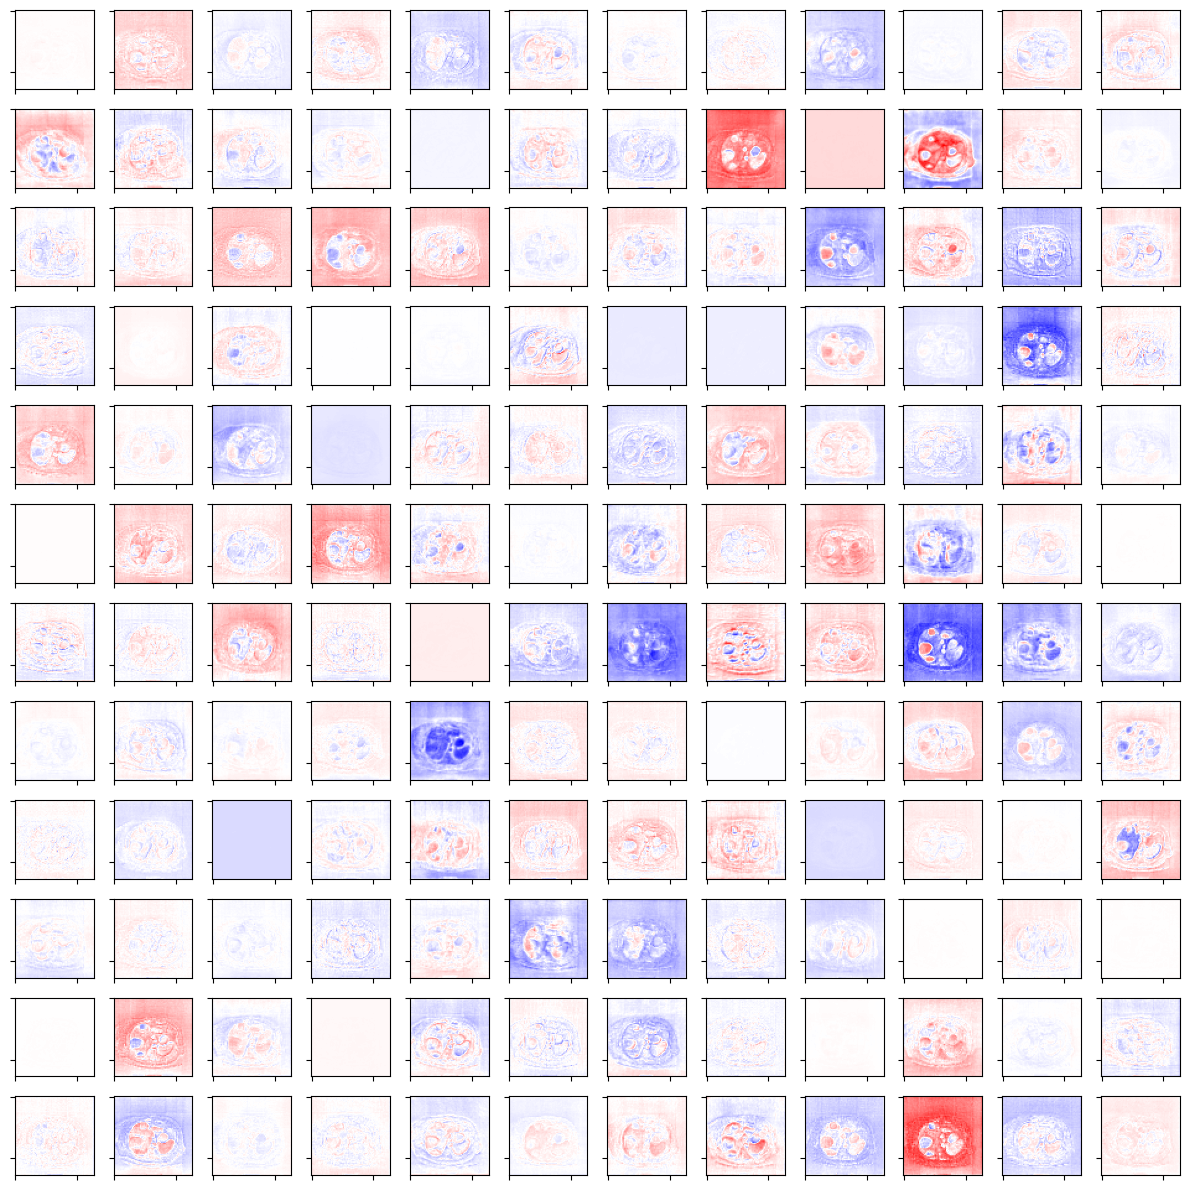

In [ ]:
plotFeaturemaps(image_embedding.squeeze(0).detach().cpu())

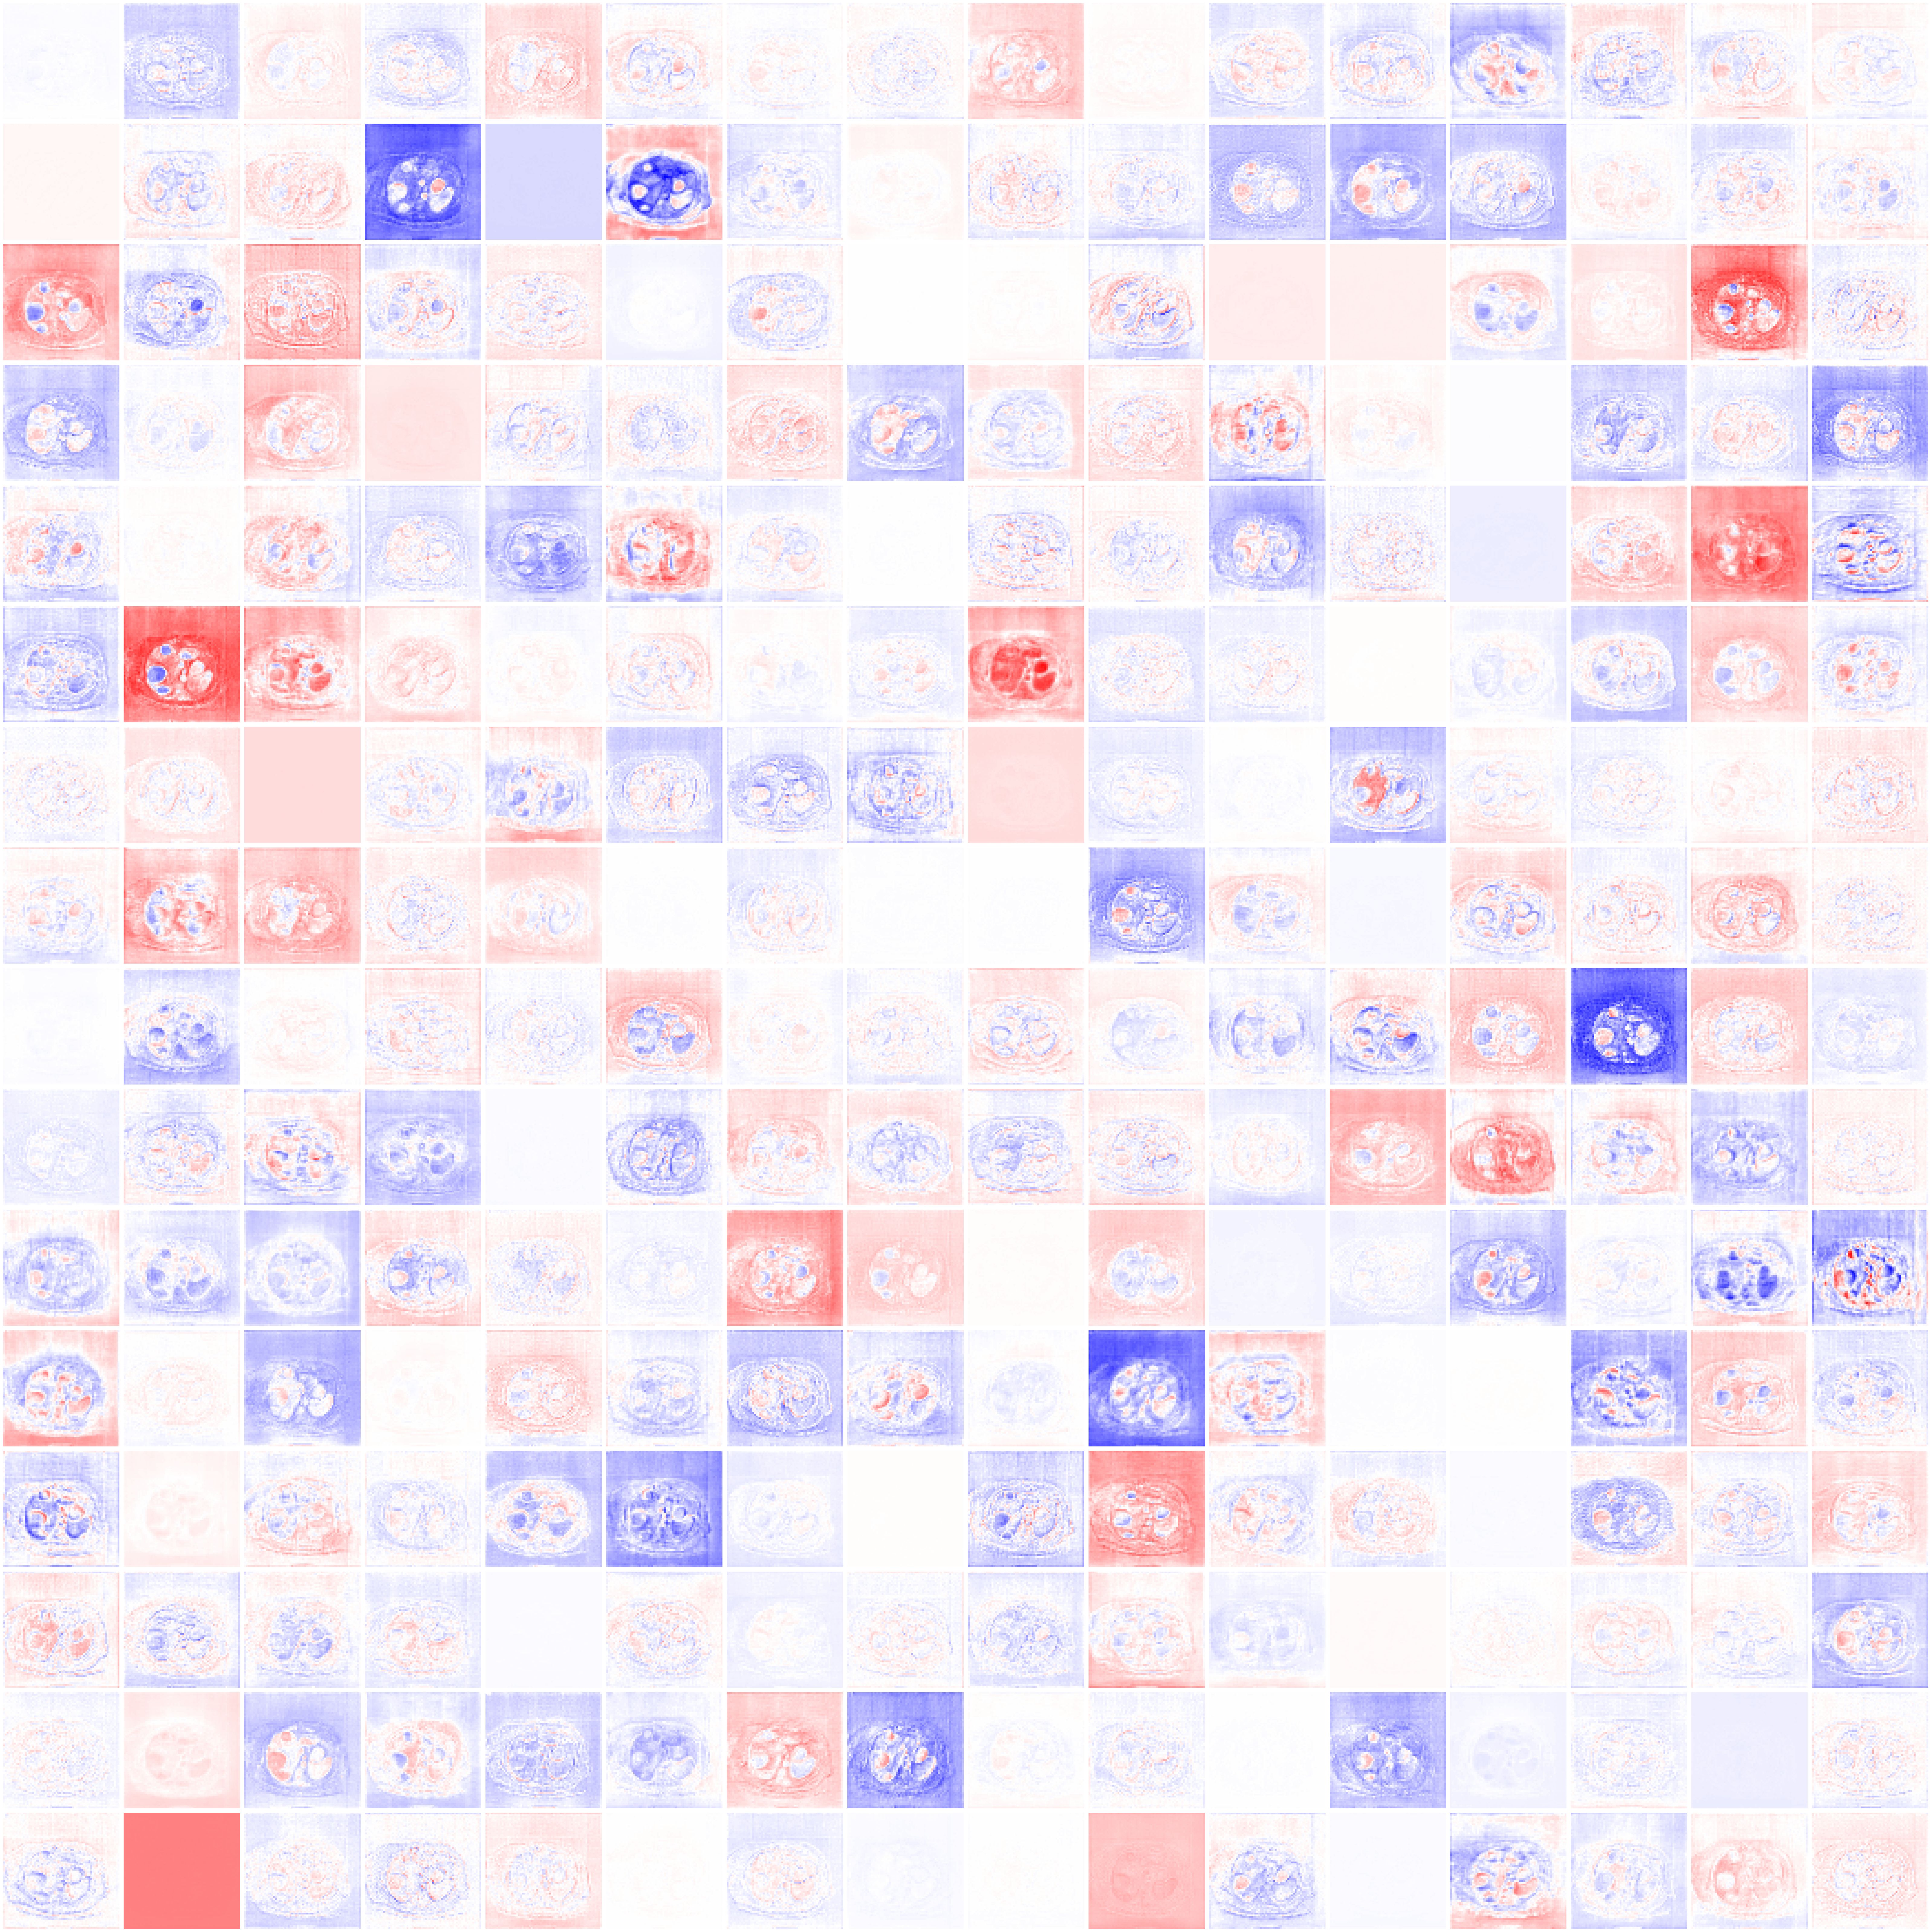

In [ ]:
import torch
scale=4
fig = plt.figure(figsize=(16*scale, 16*scale))
for i in range(image_embedding.shape[1]):
    plt.subplot(16, 16, i+1)
    plt.imshow(image_embedding[0, i].detach().cpu(), cmap='bwr', vmin=-image_embedding.abs().max(), vmax=image_embedding.abs().max())
    plt.axis("off")
plt.tight_layout()
plt.show()

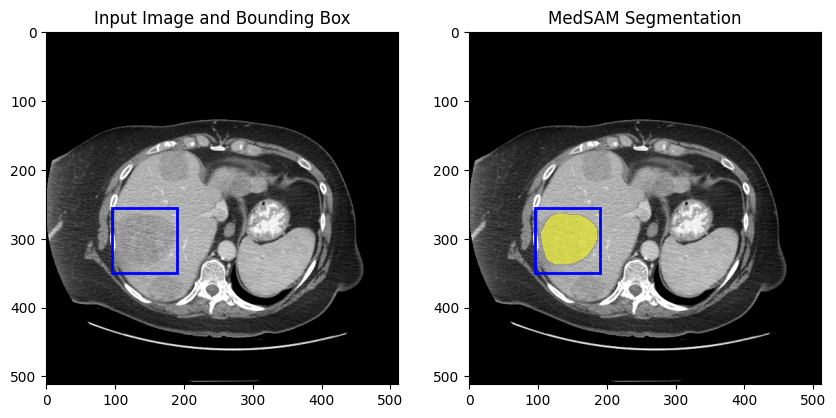

In [ ]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()